<a href="https://colab.research.google.com/github/duyendh/Convert-Pascal-VOC-to-COCO/blob/master/Betting_Game_Simul_v3_current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [1]:
import operator
import random
import pandas as pd
import os 
import numpy as np 
import matplotlib.pyplot as plt
import collections 
import pickle
import math
from tqdm.notebook import tqdm
from typing import List


from google.colab import drive
drive.mount('/content/drive',force_remount=True)
main_path = "/content/drive/My Drive/betting_scheme/data/"

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()


Mounted at /content/drive


###Data

In [2]:
with open(main_path + 'simul_data/trading_sample.pickle', 'rb') as handle:
    buying_sample = pickle.load(handle)

with open(main_path + 'simul_data/margin_sample.pickle', 'rb') as handle:
    margin_sample = pickle.load(handle)

with open(main_path + 'simul_data/trading_selling_sample.pickle', 'rb') as handle:
    selling_sample = pickle.load(handle)   

#cash balance
path = main_path + 'cash_in_balance_v1/cash_in_balance_v1.csv'
cash = pd.read_csv(path, index_col='TradeDate', usecols=['AccountID', 'TradeDate', 'Amount', 'CashBalance'], parse_dates=True)
cash = cash.loc[cash['CashBalance'] < 2e9]
cash = cash.loc[cash['AccountID'].str[-1] == '1']
cash_balance = cash['CashBalance'][cash['CashBalance'] > 0]
cash_in = cash['Amount']

###User growth

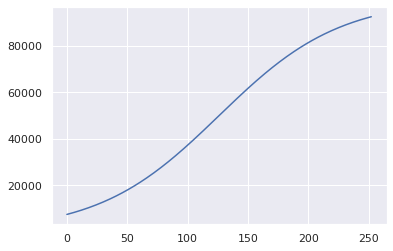

In [12]:
# User growth pattern
expected_users = 100000
growth_rate = 0.02
life_cycle = 254
time_range = [x for x in range(1,life_cycle,1)]
growth_pattern = [ expected_users/(1+np.exp(-growth_rate*(x-(life_cycle/2)))) for x in time_range]
plt.plot(growth_pattern)

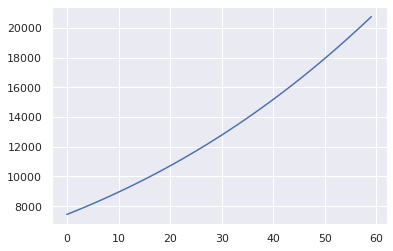

In [13]:
growth = growth_pattern[:60]
ab_growth = [int(x) for x in pd.Series(growth).diff().values[1:]]
plt.plot(growth)

###Function

In [9]:
# User growth
def user_growth(
	expected_users:int=100000, growth_rate:float=0.02,
	life_cycle:int=365,
  day_test:int=60
	):
  """
    return absolute growth per day for given number of day_test
  """
  growth_pattern = [expected_users/(1+np.exp(-growth_rate*(x-(life_cycle/2)))) for x in time_range]
  ab_growth = [int(x) for x in pd.Series(growth_pattern[:day_test]).diff().values[1:]]
  return ab_growth


# Min/max Scaling
def min_max_scaling(X):
	max_X = max(X) 
	min_X = min(X)
	X = [(x - min_X)/(max_X - min_X) for x in X]
	return X

# Softmax values
def softmax(x):
    """
    Compute softmax values for each sets of scores in x
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# Uniform choice
def binary_choice(p=0.8):
	return True if random.random() < p else False

# Split to 3 sequence for matching active level with cash balance
def split_sequence(sequence, portion=3):
	_min = min(sequence)
	_max = max(sequence)
	return (_max-_min) // portion

# Price pattern
def entry_price(
	t :int = 1,
    checkpoints: float =[0.3,0.7,1],
    based_exponential :float = 2,
    extra_cost : int =  -30,
            ):
	"""
		Entry Price of Game
		Args:
		    sub_game(int) : subgame 
		    t (int):      capstone of subgame 
	"""
	sub_game = 0
	if t > checkpoints[0]:
		sub_game = 1
		if t > checkpoints[1]:
		  sub_game = 2

	return extra_cost * sub_game +  300 *  t

###User Class

In [24]:
class USER(): 
  def __init__(self, id, conversion_rate):
    """

      id (int) : the id of user 
      point (int): accumulated silver point
      iguru_account (bool): has iguru account or not
      ssi_account (bool): has ssi account or not
      showed_portfolio (bool): decide to show portfolio or not
      cash_balance (float): the amount of cash in balance, to calculate interest
      outstanding_amount (float): the amount of money owned, accumulated each time users taking margin
      top_up_time (int): the number of time users top up, for analysis
      refer_time (int): the number of time users refer, for analysis

    """ 
    # Input
    self.id = id
    self.conversion_rate = conversion_rate

    # Point
    self.point = 0
    self.gold = 0
    self.point_converted_from_gold = 0

    # User's attributes
    self.ssi_account = False
    self.showed_portfolio = False
    self.referred = False
    self.is_margin = False
    self.link_ssi_account = False
    self.active_level = 0
    self.active_level_scaled = 0
    self.top_up_time = 0
    self.refer_time = 0
    self.be_viewed = 0
    self.view_fail = 0
    self.view_portfolio_time = 0
    self.be_followed = 0
    self.follow_guru_time = 0
    self.follow_fail = 0
    self.game_play_time = 0
    self.winning_time = 0
    self.winning_size = 0
    self.total_betting = 0
    self.stat_bet = list()
    self.cash_balance = 0
    self.outstanding_amount = 0
    self.total_buy_amount = 0
    self.total_sell_amount = 0
    self.trade_day = 0
    self.monthly_cap = {
        'trading_value': {'current': 0, 'max': 10^20}, 
        'margin_value':  {'current': 0, 'max': 10^20}, 
      } # Means no cap

  # Monthly trade and margin cap for give point
  def set_monthly_cap_value(self, max_trading_value, max_margin_value): 
    """
    only give point to trading value and margin value less than cap value,
    eg: 1 tỷ vnd, nếu trade/margin nhiều hơn 1 tỷ sẽ k được hưởng ưu đãi,
    reset theo tháng => Update no ceil/floor cap '10^20'
    """
    self.monthly_cap['trading_value']['max'] = max_trading_value
    self.monthly_cap['margin_value']['max'] = max_margin_value 
    self.monthly_cap['trading_value']['current'] = 0
    self.monthly_cap['margin_value']['current'] = 0  

  def set_active(self, active_level, active_level_scaled):
    """
      users with high active level trade more, tend to use margin, and high prob to be guru
    """
    self.active_level = active_level
    self.active_level_scaled = active_level_scaled

  def set_margin(self): 
    """
      Note: is margin account or not 
    """
    self.is_margin = True

  def add_trade_day(self): 
    self.trade_day += 1

  def add_buy_amount(self, buy_amount): 
    self.total_buy_amount += buy_amount

  def add_sell_amount(self, sell_amount): 
    self.total_sell_amount += sell_amount

  def convert_to_point(self, point): 
    gold_needed = math.floor(point * self.conversion_rate)

    if self.gold > gold_needed: 
        self.point += gold_needed / self.conversion_rate
        self.point_converted_from_gold = gold_needed / self.conversion_rate
        self.gold -= gold_needed 

        return gold_needed 
    else: 
      return None  


	#==========================================#
	#                                          #
	#			        	   SILVER		        		   #
	#                                          #
	#==========================================#

  #1 Label open iguru
  def open_account(self, point_earned):
    """
      Open iGuru Account 
    """ 
    self.point += point_earned

    return point_earned

  #2 Make referral
  def make_referral(self, point_earned): 
    """
      User making referral 
    """ 
    self.refer_time += 1
    self.point += point_earned

  #3 View/query portfolio
  def view_portfolio(self, user, point_earned):
    """
      Users decide to view other portfolio 'if they've showed theirs'. Then they
      have to spend 'point' for action. Users been viewed are earned 70% of that
      point 
    """
    if user.showed_portfolio == True:
      if point_earned > self.point: 
        can_convert = self.convert_to_point(point_earned - self.point)
        if can_convert is None: 
        #not enough point to bet and cannot convert gold 
          self.view_fail += 1
          return 0 

      self.point -= point_earned
      self.view_portfolio_time += 1
      user.point += point_earned * 0.7
      user.be_viewed += 1
      return point_earned * 0.7

    else: 
      return 0

  #4 Following/Followed Guru
  def follow_guru(self, user, point_earned):
    """
      Users decide to follow guru 'if they've showed theirs'. Then they
      have to spend 'point' for aciton. Users been followed are earned 70% of that
      point
    """

    if user.showed_portfolio == True:
      if point_earned > self.point: 
        can_convert = self.convert_to_point(point_earned - self.point)
        if can_convert is None: 
        #not enough point to bet and cannot convert gold 
          self.follow_fail += 1
          return 0 

      self.point -= point_earned
      self.follow_guru_time += 1
      user.point += point_earned * 0.7
      user.be_followed += 1
      return point_earned * 0.7

    else: 
      return 0 

	#5 Link SSI account
  def link_with_ssi_account(self, point_earned):
    if self.ssi_account == False and self.link_ssi_account == False:
      self.point += point_earned
      self.ssi_account = True
      self.link_ssi_account = True
      return point_earned
    else:
      return 0


  #==========================================#
	#                                          #
	#			        	    GOLD  	      			   #
	#                                          #
	#==========================================#
  #1 Label open ssi account THROUGH iGuru
  def open_ssi_account(self, point_earned):
    """
      Open SSI Account
    """ 
    if self.ssi_account == False:
      self.gold += point_earned
      self.ssi_account = True
      return point_earned
    else:
      return 0

 #2 New fund ========================> promote initial deposit
  def new_fund(self, amount, initial_rate=0.003, pct=0.001):
    """
      New fund promoting to initial deposit - Assuming after paid margin
    """
    if amount > 0:
      # if user has outstanding_amount, reduce this by top-up amount
      if self.outstanding_amount > 0: 
        self.outstanding_amount -= amount

        # if the amount of top up larger than outstanding_amount, 
        # add the rest to cash_balance
        if self.outstanding_amount < 0: 
          # Distinguish initial deposit
          if self.top_up_time == 0:
            self.gold -= self.outstanding_amount * initial_rate
            return self.outstanding_amount * initial_rate
          else:
            self.gold -= self.outstanding_amount * pct
            return self.outstanding_amount * pct

          self.cash_balance -= self.outstanding_amount
          self.outstanding_amount = 0
      else:
        self.cash_balance += amount

        # Distinguish initial deposit
        if self.top_up_time == 0:
          self.gold += amount * initial_rate
          return amount * initial_rate
        else:
          self.gold += amount * pct
          return amount * initial_rate

      #add top up time
      self.top_up_time += 1


  def cash_out(self, amount):
    self.cash_balance -= min(self.cash_balance, amount)

    return min(self.cash_balance, amount)

  #3 Making margin
  def make_margin(self, amount, pct):
    self.outstanding_amount += amount

    # Ceil
    if (self.monthly_cap['margin_value']['current'] + np.abs(amount)) < self.monthly_cap['margin_value']['max']:
      self.monthly_cap['margin_value']['current'] += np.abs(amount) 
      self.gold += amount * pct
      return amount * pct
    elif (self.monthly_cap['margin_value']['current'] + np.abs(amount)) >= self.monthly_cap['margin_value']['max']:
      self.monthly_cap['margin_value']['current'] += np.abs(amount) 
      amount = max(0, self.monthly_cap['margin_value']['max'] - self.monthly_cap['margin_value']['current'])
      self.gold += amount * pct
      return amount * pct

   #4 Trading
  def make_trading(self, amount, pct):
    self.cash_balance -= amount

    # Ceil
    if (self.monthly_cap['trading_value']['current'] + np.abs(amount)) < self.monthly_cap['trading_value']['max']:
      self.monthly_cap['trading_value']['current'] += np.abs(amount) 
      self.gold += amount * pct
      return amount * pct
    elif (self.monthly_cap['trading_value']['current'] + np.abs(amount)) >= self.monthly_cap['trading_value']['max']:
      self.monthly_cap['trading_value']['current'] += np.abs(amount) 
      amount = max(0, self.monthly_cap['trading_value']['max'] - self.monthly_cap['trading_value']['current'])
      self.gold += amount * pct
      return amount * pct


  # Users decide to show their portfolio - once
  def show_portfolio(self, point_earned):
    if self.showed_portfolio == False:
      self.point += point_earned
      self.showed_portfolio = True

      return point_earned
    else:
      return 0

  #==========================================#
	#                                          #
	#			        	BETTING GAME		      	   #
	#                                          #
	#==========================================#

  def _time_bet_(self,mixture_weight = [0.2, 0.3, 0.5],
    mean_time = [0.2,0.5,0.7], 
    var_time = [0.2,0.2,0.2]):
        
    z = np.random.choice(3, 1, p= mixture_weight )[0]
    time_bet = np.random.normal(mean_time[z],var_time[z]) 
    time_bet = 1 if time_bet > 1 else time_bet if time_bet > 0 else 0 
    return z, time_bet


  def playing_game(self):
    # Bet 
    z, time_bet = self._time_bet_()
    p_bet = entry_price(time_bet)

    if p_bet > self.point: 
        can_convert = self.convert_to_point(p_bet - self.point)
        if can_convert is None: 
        #not enough point to bet and cannot convert gold 
          return None 

    self.stat_bet.append(p_bet)
    self.point += -p_bet
    self.game_play_time += 1

    return z, p_bet


  def win(self, winning_size): 
    # In case winning
    self.winning_time += 1
    self.winning_size += winning_size
    self.gold += winning_size

  #==========================================#
	#                                          #
	#				        DATA TO DICT	       		   #
	#                                          #
	#==========================================#
    
  def to_dict(self):
    return {
          'point_from_gold': self.point_converted_from_gold,
          'id' : self.id,
          'point' : self.point,
          'gold' : self.gold, 
          'ssi_account' : self.ssi_account, 
          'link_ssi_account' : self.link_ssi_account,
          'referred' : self.referred,
          'showed_portfolio' : self.showed_portfolio,
          'cash_balance' : self.cash_balance,
          'outstanding_amount' : self.outstanding_amount,
          'top_up_time' : self.top_up_time, 
          'refer_time' : self.refer_time, 
          'active_level' : self.active_level,
          'active_level_scaled' : self.active_level_scaled,
          'is_margin' : self.is_margin, 
          'trade_day' : self.trade_day,
          'total_buy_amount' : self.total_buy_amount,
          'total_sell_amount' : self.total_sell_amount, 
          'be_viewed': self.be_viewed,
          'view_portfolio_time': self.view_portfolio_time, 
          'be_followed': self.be_followed,
          'follow_guru_time': self.follow_guru_time,
          'game_play_time': self.game_play_time,
          'total_betting': self.total_betting, 
          'winning_time' : self.winning_time,
          'winning_size' : self.winning_size,
          'follow_fail' : self.follow_fail,
          'view_fail' : self.view_fail,
          }

###Simulation Class

(array([2612., 2533., 1545.,  955.,  640.,  405.,  306.,  197.,  164.,
         143.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

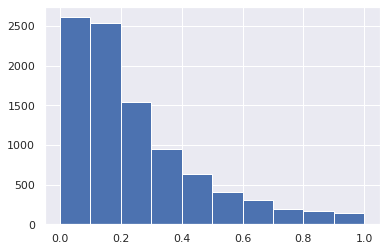

In [ ]:
#active level 
n = 10000
active_levels = sorted([max(0, x) for x in np.random.lognormal(2, 1, size=n)])[:int(n*0.95)]
np.random.shuffle(active_levels)
active_levels_scaled = min_max_scaling(active_levels)
plt.hist(active_levels_scaled)

In [36]:
class SIMULATION(): 
  def __init__(self, 
               expected_users: int,
               avg_trade: int,
               ab_growth: List[int], 
               cash_balance: List[float],
               cash_in: List[float], 
               selling_sample: List[float], 
               buying_sample: List[float], 
               margin_sample: List[float]):
    """ 
        expected_users: the number of expected users at the end of the period 
        ab_growth: absolute growth each day
        cash_balance: real cash balance sample of one day
        cash_in: real cash in sample of one day 
        selling_sample: real selling sample of one day
        buying_sample: real buying sample of one day 
        margin_sample: real margin sample of one day
    """
    self.count = 0

    #real data
    self.cash_in = cash_in 
    self.cash_balance = cash_balance
    self.selling_sample = selling_sample
    self.buying_sample = buying_sample 
    self.margin_sample = margin_sample

    #assumption variables
    self.refer_rate = None

    #assumption based on distributions 
    self.avg_trade = avg_trade
    self.ab_growth = ab_growth
    # self.active_levels = [max(0, x) for x in np.random.lognormal(2, 1, size=expected_users)]  #old : 0.5, 0.5 
    self.active_levels = sorted([max(0, x) for x in np.random.lognormal(2, 1, size=expected_users)])[:int(expected_users*0.95)]
    np.random.shuffle(self.active_levels)
    self.active_levels_scaled = min_max_scaling(self.active_levels)
    self.pct_buy = np.random.normal(avg_trade, 1, size=len(ab_growth))
    self.pct_sell = np.random.normal(avg_trade, 1, size=len(ab_growth))
    # self.game_spent = [max(0, x) * (game_spent_avg/2) for x in np.random.normal(2, 1, size=expected_users)]
    self.active_levels_portion = split_sequence(self.active_levels, portion=3)
    self.cash_balance_portion = split_sequence(self.cash_balance, portion=3)
    
    #population variables 
    self.users_base = []
    self.stat_bet = []
    self.count = 0

    #variables for statistics report 
    self.stat_dict = {
      'guru_account_total' : 0, 
      'open_account_total' : 0,
      'link_account_total': 0,
      'make_referral_total' : 0,
      'new_fund_total' : 0,
      'interest_total' : 0,
      'make_trading_total' : 0,
      'make_margin_total': 0,
      'view_portfolio_total' : 0,
      'show_portfolio_total' : 0,
      'follow_guru_total' : 0,
      'game_spent_total' : 0,
      'winning_game_total' : 0
      }
    self.betting = []

    # points allocation simulation 
    self.open_guru_account_point = None
    self.open_account_point = None
    self.link_ssi_account_point = None
    self.make_referral_point = None
    self.show_portfolio_point = None 
    self.view_portfolio_point = None
    self.follow_guru_point = None 
    self.trading_pct = None 
    self.initial_fund_pct = None
    self.fund_pct = None
    self.margin_pct = None 
    self.conversion_rate = None 
    self.user_winning_pct = [20/100, 30/100, 50/100]
    self.winning_pct = None
    self.max_trading_value = None
    self.max_margin_value = None
    

  def set_simulation_variables(self, open_guru_account_point, open_account_point, link_ssi_account_point, 
                               make_referral_point, be_referred_rate, show_portfolio_point, view_portfolio_point, 
                               follow_guru_point, initial_fund_pct, fund_pct, trading_pct, margin_pct, 
                               conversion_rate, winning_pct, max_trading_value, max_margin_value):
    
       #Gold
    self.open_account_point = open_account_point
    self.show_portfolio_point = show_portfolio_point
    self.trading_pct = trading_pct
    self.margin_pct = margin_pct
    self.initial_fund_pct = initial_fund_pct
    self.fund_pct = fund_pct

       #Silver 
    self.open_guru_account_point = open_guru_account_point
    self.link_ssi_account_point = link_ssi_account_point
    self.make_referral_point = make_referral_point
    self.view_portfolio_point = view_portfolio_point
    self.follow_guru_point = follow_guru_point

  
     # Others
    self.conversion_rate = conversion_rate 
    self.winning_pct = winning_pct
    self.max_trading_value = max_trading_value
    self.max_margin_value = max_margin_value
    self.be_referred_rate = be_referred_rate


  def add_new_user(self,user_num, total_refer):
    """ 
        add new user, set active level, set ssi_account, set margin, give initial fund, set who will show their porfolio
        user_num: number of users
    """
    new_users_base = []

    for num in range(user_num):
      user = USER(self.count, self.conversion_rate)
      user.set_monthly_cap_value(max_trading_value, max_margin_value)
      point_earned = user.open_account(self.open_guru_account_point)
      self.stat_dict['guru_account_total'] += point_earned

      if num < total_refer: 
          user.point += self.make_referral_point * self.be_referred_rate

      #set active level
      user.set_active(self.active_levels[self.count], self.active_levels_scaled[self.count]) 

      # @tuan added: depending on active level, cash_balance are also randomness from
      cash_balance_splitted = self.cash_balance[self.cash_balance > (
          min(self.cash_balance) + self.cash_balance_portion * (math.floor(
          self.active_levels[self.count] // self.active_levels_portion) - 0.1)
          )]

      #set users who will open ssi_acount and give them initial balance 
      if binary_choice() and user.active_level_scaled > 0:
        if binary_choice(0.5): #binary_choice(0.8) sẽ random trong 0.8, nên binary_choice() > 0.4 = binary_choice(0.5)
          point_earned = user.open_ssi_account(self.open_account_point)
          self.stat_dict['open_account_total'] += point_earned    
        else: 
         point_earned = user.link_with_ssi_account(self.link_ssi_account_point)
         self.stat_dict['link_account_total'] += point_earned
        
        _amount = random.choice(cash_balance_splitted)          
        point_earned = user.new_fund(amount=_amount,initial_rate=self.initial_fund_pct, pct=self.fund_pct) 
        self.stat_dict['new_fund_total'] += point_earned

        #set users who will get a margin 
        if binary_choice(0.45) or user.active_level_scaled > 0.7: 
          user.set_margin()

       #set user who will choose to show portfolio   
        if binary_choice(0.6) and user.active_level_scaled > 0.1 and user.ssi_account is True:
          point_earned = user.show_portfolio(self.show_portfolio_point)
          self.stat_dict['show_portfolio_total'] += point_earned

        #those who does not have ssi account won't trade:
        if user.ssi_account is False: 
          user.active_level = 0 
          user.active_level_scaled = 0

      self.users_base.append(user)
      self.count += 1

  def referral_program(self,total_refer): 
    """ 
        pick who make referral today 
        total_refer: total number of referrals made
    """
    refer_base = [u for u in self.users_base if u.refer_time < 6]
    weights = softmax([u.active_level_scaled for u in refer_base])
    refer_users = np.random.choice(refer_base, size = total_refer, p = weights, replace=False)

    for user in refer_users:
      user.make_referral(self.make_referral_point)
    self.stat_dict['make_referral_total'] += self.make_referral_point * total_refer * (1 + self.be_referred_rate)

    
  def daily_activities(self):
    """ 
        run daily activities: top up, follow guru, view portfolio 
        total_refer: total number of referrals made 
    """
    for user in self.users_base: 
      # Randomness 9% user would top_up with random choice form 
      # 'SSI cash in' on given day
      if binary_choice(0.09): 
        user.new_fund(amount = random.choice(self.cash_in))

        # Follow guru: 10% users decide follows gurus 'if guru showed 
        # their portfolio -> so the probability is lower'
        # Randomly they will follow from 0 - 4 guru
        if binary_choice(0.5):
          for i in range(random.randint(1,7)):  
            point_earned = user.follow_guru(
              random.choice(self.users_base), self.follow_guru_point
              )
            self.stat_dict['follow_guru_total'] += point_earned #phan point tiet kiem duoc sau khi tra cho nguoi duoc followed

        # Similar with follow_guru
        if binary_choice(0.9):
          for i in range(random.randint(1,12)):
            point_earned = user.view_portfolio(
              random.choice(self.users_base), self.view_portfolio_point
              )
            self.stat_dict['view_portfolio_total'] += point_earned #phan point tiet kiem duoc sau khi tra cho nguoi duoc viewed
      
  def trading(self, i): 
    """ 
        trading activities including buying, selling and making margin
        i (int): day ith    """
    if i % 20 == 0: 
      for u in self.users_base: 
        u.set_monthly_cap_value(self.max_trading_value, self.max_margin_value)

    random_buying = []
    number_users_buy = int(self.pct_buy[i]/100 * len(self.users_base))
    for n in range(number_users_buy): 
      r = random.choice(self.buying_sample)
      random_buying.append(r)
    random_buying.sort()
  
    buy_today = []

    #loop until the number of users buying equal to number_users_buy
    while (len(buy_today) < number_users_buy): 
      for u in self.users_base: 
        if binary_choice(u.active_level_scaled) and u.id not in buy_today and u.trade_day < 100: 
          id_amount = max(0, int(u.active_level_scaled * len(random_buying)) - 1)         
          # print(u.monthly_cap)
          #buying behaviour of margin user
          if u.is_margin: 
            buy_amount = np.random.choice(random_buying[id_amount : min(id_amount + 400, number_users_buy)])
            buy_today.append(u)
            u.add_buy_amount(buy_amount)
           
            if buy_amount > u.cash_balance:                   
              point_earned = u.make_trading(u.cash_balance, self.trading_pct)
              self.stat_dict['make_trading_total'] += point_earned 

              margin_amount = buy_amount - u.cash_balance 
              point_earned = u.make_margin(margin_amount, self.margin_pct)
              self.stat_dict['make_margin_total'] += point_earned

            
            else:   
                point_earned = u.make_trading(buy_amount, self.trading_pct)
                self.stat_dict['make_trading_total'] += point_earned


          #buying behaviour of non-margin user
          else:
            buy_amount = np.random.choice(random_buying[max(0, id_amount-100): min(id_amount + 100, number_users_buy)])
            if u.cash_balance > 0:
              buy_amount = min(u.cash_balance, buy_amount)  
              u.add_buy_amount(buy_amount)
              point_earned = u.make_trading(buy_amount, self.trading_pct)  
              self.stat_dict['make_trading_total'] += point_earned
  
              buy_today.append(u)

    ###SELLING
    random_selling = []
    number_users_sell = int(self.pct_sell[i]/100 * len(self.users_base))
    for n in range(number_users_sell): 
      r = random.choice(self.selling_sample)
      random_selling.append(r)
    random_selling.sort()

    sell_today = []
    while (len(sell_today) < number_users_sell): 
      for u in self.users_base: 
        if binary_choice(u.active_level_scaled) and u.id not in sell_today and u.trade_day < 100:     
          id_amount = max(0, int(u.active_level_scaled * len(random_selling)) - 1)         
          sell_amount = np.random.choice(random_selling[max(0, id_amount-100): min(id_amount + 200, number_users_sell)])
          u.add_sell_amount(sell_amount)
          point_earned = u.make_trading(sell_amount, self.trading_pct)  
          self.stat_dict['make_trading_total'] += point_earned  
          # print('point_earned',  point_earned, sell_amount)  
          sell_today.append(u)


    #UPDATE
    trade_today = set(sell_today + buy_today)
    for u_trade in trade_today:
      u_trade.add_trade_day() 

  def end_of_day_activities(self):

    #cash_out
    for user in self.users_base:
      if binary_choice(0.09): 
        cash_out_amount = user.cash_out(amount = 0.5*random.choice(self.cash_in))
        # print('cash_out_amount', cash_out_amount)

  def betting_game(self): 

    #players_base: các players sẽ được xếp vào 3 nhóm tùy vào thời điểm họ tham gia, hiện tại người thắng cuộc đang chọn trong từng nhóm 
    #nhưng có lẽ nên sửa là người thắng cuộc ở nhóm 3 có thể thuộc cả 3 nhóm chứ nhỉ

    players_base = [[] for i in range(3)]
    money_bet = [0] * 3

    random.shuffle(self.users_base)
    for user in self.users_base: 
      if binary_choice(0.25): 
        g_result = user.playing_game()

        #g_result chứa mini game mà họ tham gia (thời điểm z đặt bet) và size bet
        if g_result is not None: 
          mini_game, betting_size = g_result
          self.betting.append(betting_size)
          players_base[mini_game].append(user)
          money_bet[mini_game] += betting_size

    #để report, thêm tổng lượng money bet của ngày hôm đó vào game_spent_total
    self.stat_dict['game_spent_total'] += sum(money_bet)
  
    #current_money_bet để giữ lượng tiền còn lại (sau khi đã trả thưởng)
    current_money_bet = 0 
    for i, mini_game in enumerate(players_base):  
      #chọn random winner
      winners = np.random.choice(mini_game, size=3)
      #thêm tổng lượng bet ở chặng i vào current_money_bet
      current_money_bet += money_bet[i]
      #chỉ lấy x% lượng bet hiện tại để trả thưởng
      total_winning_size = current_money_bet * self.winning_pct[i]
      current_money_bet  -= total_winning_size 

      for winner, pct_win in zip(winners, self.user_winning_pct): 
        #trả thưởng bằng gold nên phải có conversion rate
        winning_size = np.clip(pct_win * total_winning_size * self.conversion_rate, 1, 20)
        #update winning_size bằng gold cho winner
        winner.win(winning_size) 
        #update winning_game_total để report
        self.stat_dict['winning_game_total'] += winning_size
     

  def adjust_gold_silver(self): 
    silver_group = ['guru_account_total', 'view_portfolio_total', 'follow_guru_total','game_spent_total', 'make_referral_total']
    for each in silver_group:
      self.stat_dict[each] = self.stat_dict[each] * self.conversion_rate

  def run_simul(self, refer_rate = 0.6): 
    """ 
      run simulation
      refer_rate: how many percentage of customers will make referall
    """
    self.refer_rate = refer_rate

    for i, user_num in tqdm(enumerate(self.ab_growth)):
      # if day 0, no one is making referral
      if i == 0:
        total_refer = 0 
      else: 
        #else, x% users come from referral program
        total_refer = int(user_num * self.refer_rate)

        #make referral
        self.referral_program(total_refer)

      #add new user and generate behaviour 
      self.add_new_user(user_num, total_refer)

      #daily activities: top up, view, follow
      self.daily_activities()

      #trading: buy, sell, make margin
      self.trading(i)
    
      if i > 10:
      #betting game
        self.betting_game()

      #end of day activities : cash out
      self.end_of_day_activities()

    #dataframe for reporting
    user_df = pd.DataFrame.from_records([s.to_dict() for s in self.users_base])

    #adjusted cost to gold 
    self.adjust_gold_silver()

    return user_df, self.stat_dict

In [40]:
ab_growth = user_growth(life_cycle=254, day_test=60)
expected_users = expected_users
avg_trade = 8 
conversion_rate = 0.001
winning_pct = [10/100, 20/100, 30/100]

max_trading_value = 10**10
max_margin_value = 10**10
#==============================================#

	#==========================================#
	#                                          #
	#			        	    GOLD  	      			   #
	#                                          #
	#==========================================#

open_account_point = 0.5
show_portfolio_point = 500
trading_pct = 0.0009/10**6
margin_pct = 0.0004/10**6
initial_fund_pct = 0.003/10**6
fund_pct = 0.001

	#==========================================#
	#                                          #
	#			        	   SILVER  	      			   #
	#                                          #
	#==========================================#

open_guru_account_point = 400
link_ssi_account_point = 500
make_referral_point = 800
be_referred_rate = 0.5 #referee earned half of referrer
view_portfolio_point = 50
follow_guru_point = 100

#===============================================#

simul = SIMULATION(expected_users = expected_users,
                   ab_growth = ab_growth, 
                   cash_balance = cash_balance,
                   cash_in = cash_in,
                   selling_sample = selling_sample,
                   buying_sample = buying_sample,
                   margin_sample = margin_sample,
                   avg_trade = avg_trade)

simul.set_simulation_variables(open_guru_account_point = open_guru_account_point, 
                               open_account_point = open_account_point, 
                               link_ssi_account_point = link_ssi_account_point,
                               make_referral_point = make_referral_point,
                               be_referred_rate = be_referred_rate,
                               show_portfolio_point = show_portfolio_point, 
                               view_portfolio_point = view_portfolio_point, 
                               follow_guru_point = follow_guru_point, 
                               initial_fund_pct = initial_fund_pct,
                               fund_pct = fund_pct, 
                               trading_pct = trading_pct, 
                               margin_pct = margin_pct, 
                               conversion_rate = conversion_rate, 
                               winning_pct = winning_pct,
                               max_trading_value = max_trading_value,
                               max_margin_value = max_margin_value)

user_df, stat_dict = simul.run_simul()

#Statistics

In [42]:
stat_series = pd.Series(stat_dict)
stat_series

guru_account_total      5.309200e+03
open_account_total      2.645000e+03
link_account_total      2.671500e+06
make_referral_total     9.422400e+03
new_fund_total          1.232600e+04
interest_total          0.000000e+00
make_trading_total      5.490266e+03
make_margin_total       2.742487e+03
view_portfolio_total    2.202270e+03
show_portfolio_total    2.336500e+06
follow_guru_total       1.505000e+03
game_spent_total        1.071187e+04
winning_game_total      3.092317e+03
dtype: float64

Total spending:  44734.93974376779
Percentage spending in gold:  0.5878194962234459


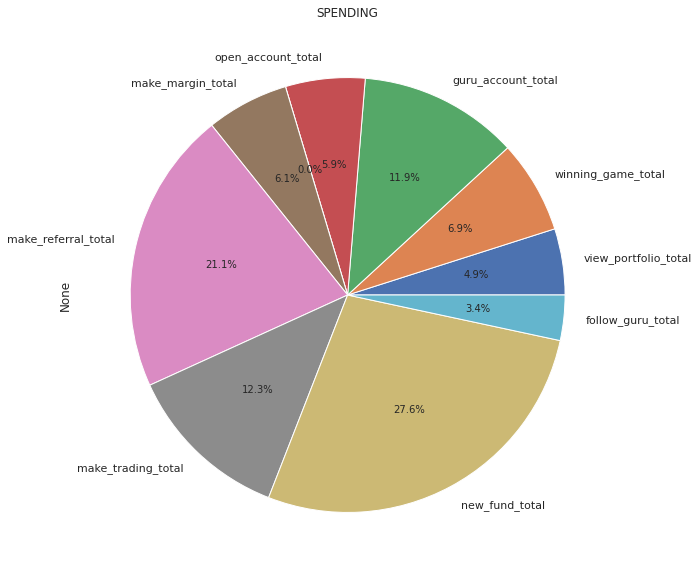

In [43]:
spending = stat_series.reindex(['view_portfolio_total','winning_game_total', 'guru_account_total','open_account_total','interest_total','make_margin_total', 
              'make_referral_total', 'make_trading_total','new_fund_total', 'follow_guru_total'])
spending_in_gold = spending.reindex(['winning_game_total', 'open_account_total', 'interest_total', 'make_margin_total', 'make_trading_total', 'show_portfolio_total',
                                     'new_fund_total'])
fig = plt.figure(figsize=(10,10))
print('Total spending: ', spending.sum())
print('Percentage spending in gold: ', spending_in_gold.sum()/spending.sum())
plt.title('SPENDING')
spending.plot.pie(autopct="%.1f%%");

Total saving:  10711.874642884228
Percentage saving:  0.4073564889073569


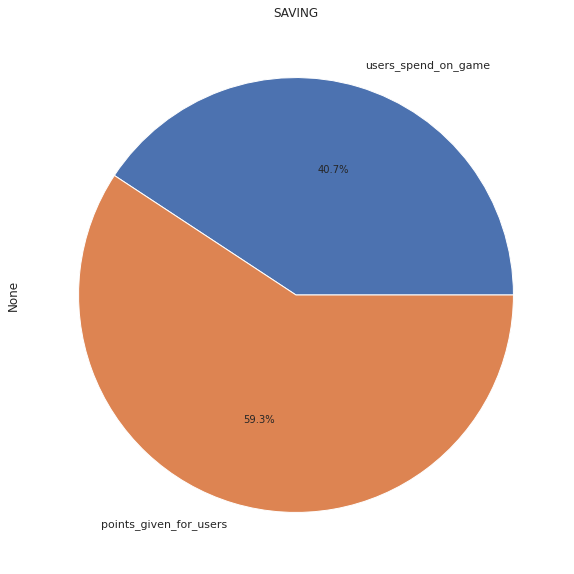

In [44]:
receiving = pd.Series(dtype=object)
receiving['users_spend_on_game'] = stat_series['game_spent_total']
receiving['points_given_for_users'] = spending_in_gold.sum() - receiving['users_spend_on_game']
fig = plt.figure(figsize=(10,10))
print('Total saving: ', receiving['users_spend_on_game'])
print('Percentage saving: ', receiving['users_spend_on_game']/spending_in_gold.sum())
plt.title('SAVING')
receiving.plot.pie(autopct="%.1f%%");

statistics

In [ ]:
print('total gold in community', user_df['gold'].sum())
print('total gold in community excluding winning price', user_df['gold'].sum() - user_df['winning_size'].sum())
print('total silver point in community', user_df['point'].sum())
print('total trading value', user_df['total_buy_amount'].sum() + user_df['total_sell_amount'].sum())

total gold in community 139403.73786217056
total gold in community excluding winning price 137519.48548670585
total silver point in community 21717725.626842335
total trading value 16843374840082.5


(array([2386., 1596., 3435., 5070., 3875., 4455., 7741., 5547., 2471.,
        2915.]),
 array([  0.,  24.,  48.,  72.,  96., 120., 144., 168., 192., 216., 240.]),
 <a list of 10 Patch objects>)

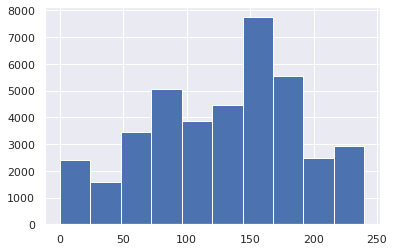

In [ ]:
plt.hist(simul.betting)

In [ ]:
user_df['point'].sort_values(ascending=False)[:20]

585     24360.635241
4391    23644.555473
1029    23504.386106
3956    23206.650390
5537    23108.087137
2098    23106.345328
1233    23060.470253
3188    23011.189219
3638    22910.248353
1323    22901.130373
705     22863.101595
5137    22811.352127
5489    22722.584522
1518    22676.986483
1360    22643.660857
5078    22558.730479
3449    22505.369184
3952    22459.901855
2494    22357.755726
1387    22268.387452
Name: point, dtype: float64

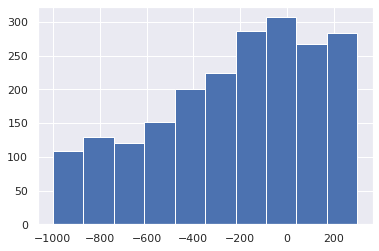

In [ ]:
user_df[(user_df['point'] < 300)]['point'].hist()

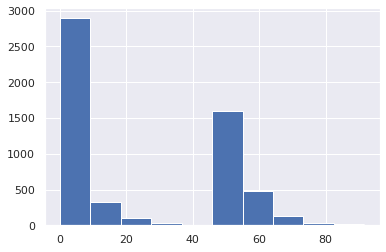

In [ ]:
user_df[user_df['gold'] < 5000]['gold'].hist()

In [ ]:
print(user_df['is_margin'].value_counts())

False    3439
True     2169
Name: is_margin, dtype: int64


(array([952., 978., 787., 965., 803., 632., 362.,  96.,  27.,   6.]),
 array([ 0. ,  6.6, 13.2, 19.8, 26.4, 33. , 39.6, 46.2, 52.8, 59.4, 66. ]),
 <a list of 10 Patch objects>)

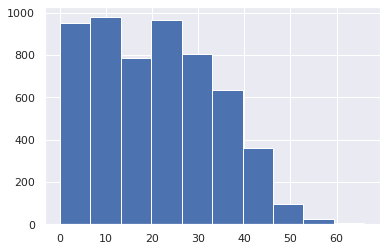

In [ ]:
plt.hist(user_df['follow_guru_time']) # .hist()

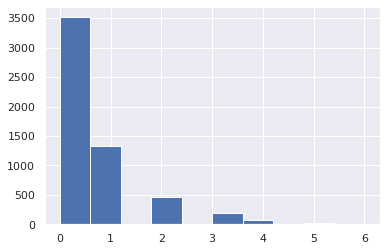

In [ ]:
user_df['refer_time'].hist()

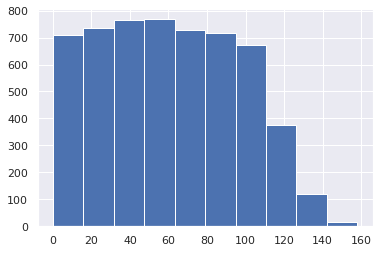

In [ ]:
user_df['view_portfolio_time'].hist()

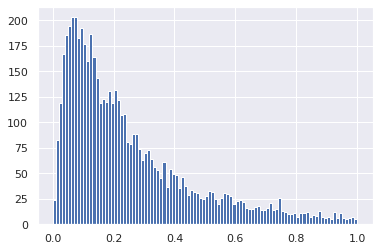

In [ ]:
user_df['active_level_scaled'].hist(bins=100)

In [ ]:
print('total point converted from gold: ', user_df['point_from_gold'].sum())
print('percentage: ', user_df['point_from_gold'].sum()/user_df['point'].sum())

total point converted from gold:  48000.0
percentage:  0.002210176186251921


(array([424., 154., 121., 109.,  84.,  76.,  66.,  59.,  62.,  49.]),
 array([0.0000000e+00, 9.9897120e+07, 1.9979424e+08, 2.9969136e+08,
        3.9958848e+08, 4.9948560e+08, 5.9938272e+08, 6.9927984e+08,
        7.9917696e+08, 8.9907408e+08, 9.9897120e+08]),
 <a list of 10 Patch objects>)

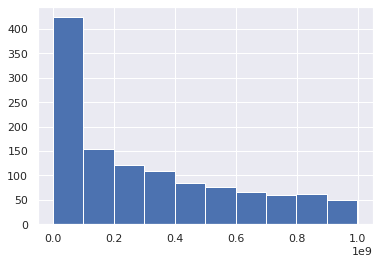

In [ ]:
plt.hist(user_df[user_df['cash_balance'] < 1000000000]['cash_balance'])

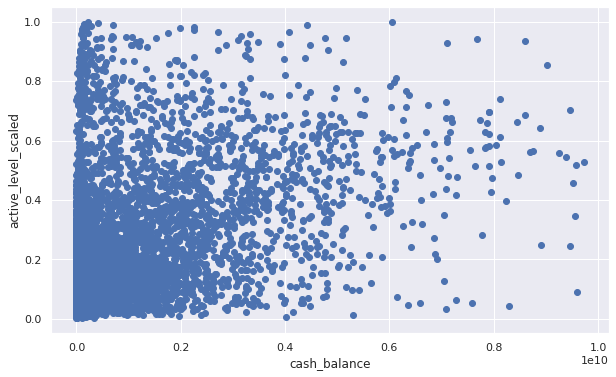

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
compare = 'cash_balance'
ax.scatter(x = user_df[user_df['cash_balance'] < 10000000000][compare], y = user_df[user_df['cash_balance'] < 10000000000]['active_level_scaled'])
plt.xlabel(compare)
plt.ylabel('active_level_scaled')

plt.show()

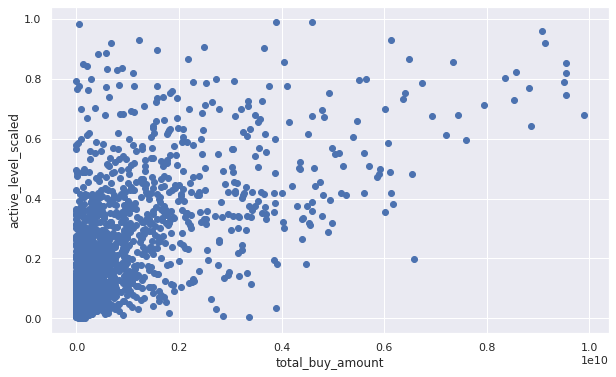

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
compare = 'total_buy_amount'
ax.scatter(x = user_df[user_df['total_buy_amount'] < 10000000000][compare], y = user_df[user_df['total_buy_amount'] < 10000000000]['active_level_scaled'])
plt.xlabel(compare)
plt.ylabel('active_level_scaled')

plt.show()